## Toy Model 1: 2 spatial modes with different oscillating frequencies

### Created by Yuying Liu, 09/23/2019

$$\Phi(x, t) = u(x)cos(\omega_0 t) + v(x)cos(\omega_1 t + \frac{\pi}{4})$$

In [1]:
# imports
import os
import sys
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

module_path = os.path.abspath(os.path.join('../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import torch_cae_multilevel_V4 as net
import ResNet as tnet
import utils

## MrCAE

Below is the progressive training framework. 
One could have flexible control over each training step: low-level models are cheap to obtain, and higher level models are built based on them -- one can always revert back to the previous level and adjust the parameters to re-train the model if it is not satisfying. 

In [2]:
# init model & load data
data_path = '../data/toy2'
model_path = '../model/toy2'
result_path = '../result/toy2/'

full_data_path = os.path.join(data_path, 'data.npy')
data = np.load(full_data_path)

torch.Size([5000, 2, 2])


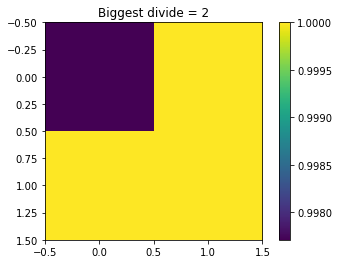

torch.Size([5000, 2, 2])
size_small =  2
size_max =  4
current_size =  4


C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\utils.py:182: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data)


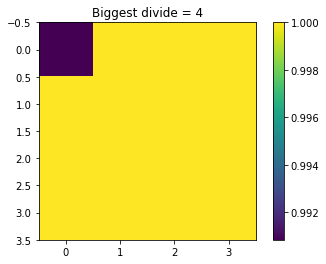

current_data shape =  (5000, 4, 4)
next_data shape =  torch.Size([5000, 8, 8])
size_small =  4
size_max =  8
current_size =  8


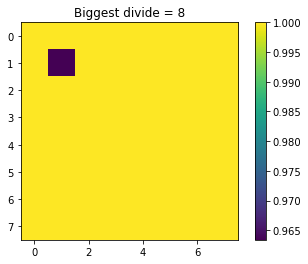

current_data shape =  (5000, 8, 8)
next_data shape =  torch.Size([5000, 16, 16])
size_small =  8
size_max =  16
current_size =  16


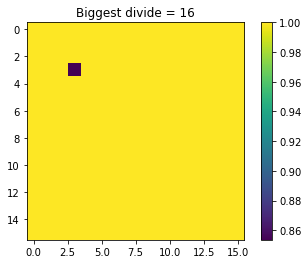

current_data shape =  (5000, 16, 16)
next_data shape =  torch.Size([5000, 32, 32])
size_small =  16
size_max =  32


In [3]:
unresolved_dict = {}
data_levels_dict = {}

#predict 2x2 and graph
current_size = 2
next_size = current_size * 2
resolved = False
current_data = utils.data_of_size(data,current_size)#utils.grow(utils.data_of_size(data,current_size))
next_data = utils.data_of_size(data,next_size)#utils.grow(utils.data_of_size(data,next_size))

print(current_data.shape)
plt.imshow(current_data[0])
plt.title("Biggest divide = "+str(current_size))
plt.colorbar()
plt.show()
print(current_data.shape)
resolved, loss, unresolved = utils.MSE(current_data, next_data, current_size)
unresolved_dict[str(current_size)] = unresolved
data_levels_dict[str(current_size)] = current_data

while resolved == False:

    current_data = utils.make_next_layer(next_data, current_data, unresolved)
    current_size =current_size * 2
    next_size = current_size * 2
    print("current_size = ", current_size)
    next_data = utils.data_of_size(data,next_size)#utils.grow(utils.data_of_size(data,next_size))
    plt.imshow(current_data[0])
    plt.title("Biggest divide = "+str(current_size))
    plt.colorbar()
    plt.show()
    
    print("current_data shape = ", current_data.shape)
    print("next_data shape = ", next_data.shape)
    
    resolved, loss, unresolved = utils.MSE(current_data, next_data, current_size)
    
    unresolved_dict[str(current_size)] = unresolved
    data_levels_dict[str(current_size)] = current_data




(5000, 16, 16)
(16, 16)


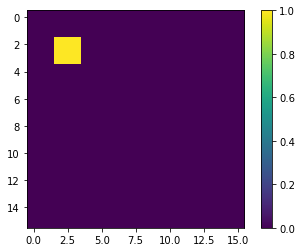

(5000, 4)


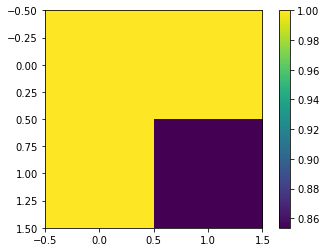

In [58]:
# print(unresolved_dict['8'].float())
# print(data_levels_dict['16'])

to_fit = (1-utils.grow(unresolved_dict['8'].float(),16))*data_levels_dict['16']
# imshow(to_)
print(to_fit.shape)
# plt.imshow(to_fit[0])
# plt.colorbar()

# res = np.argwhere(to_fit[0] == 0)
# res = np.nonzero(to_fit[0]  == 0)
# print(len(res))
# print(res[0].shape)

print((to_fit[0]>0).shape)
plt.imshow(to_fit[0]>0)
plt.colorbar()
plt.show()

keep = to_fit[:,to_fit[0]>0]
print(keep.shape)

plt.imshow(keep[0].reshape(2,2))
plt.colorbar()

# plt.imshow(res[0])
# plt.colorbar()
# plt.show()

In [5]:
graph = (utils.grow(data_levels_dict['4'], 4) * (1-utils.grow(unresolved_dict['2'], 4)))#.reshape((5000,1,4,4))
keep = np.repeat( (1-utils.grow(unresolved_dict['2'], 4)), 5000, axis = 0)
print("keep shape = ", keep.shape)

print("(1-utils.grow(unresolved_dict['2'], 4)) shape = ", (1-utils.grow(unresolved_dict['2'], 4)).shape)
print("graph shape = ", graph.shape)
# smaller = [i for (i, v) in zip(graph, (1-utils.grow(unresolved_dict['2'], 4))) if v]
smaller = graph[keep.astype(bool)].reshape(5000,)
# smaller = np.ma.masked_array(graph, mask=(1-utils.grow(unresolved_dict['2'], 4)))
# smaller = graph[np.where(graph>0)]
print("smaller shape = ", smaller.shape)
plt.imshow(smaller[0])
plt.colorbar()

keep shape =  (5000, 4, 4)
(1-utils.grow(unresolved_dict['2'], 4)) shape =  (1, 4, 4)
graph shape =  (5000, 4, 4)


ValueError: cannot reshape array of size 20000 into shape (5000,)

In [ ]:
to_graph = data_levels_dict['8']*(1-unresolved_dict['8'].numpy())
plt.imshow(to_graph[0])
plt.colorbar()

# This is where some time stuff will start eventually 

In [4]:

# print(model_space.cur_level)
# # all_data = dataset.obtain_data_at_current_level_all(model_space.cur_level)
# print(all_data.shape)
# train_data, val_data, test_data =dataset.obtain_data_at_current_level(model_space.cur_level)
# encoded = model_space.encode(all_data, model_space.cur_level)
# print(encoded.shape)

data_this = data_levels_dict['2']
print(data_this.shape)
n = len(data_this)

train_data_raw = data_this[:int(n*0.8),:,:]
print(train_data_raw.shape)
random_starts = np.random.randint(0,4000 - 500, 100)
train_data = torch.zeros((100,500,4))
for (i,r) in enumerate(random_starts):
    train_data[i] = train_data_raw[r:r+500,:,:].reshape(1,500,4)

val_data = data_this[int(n*0.8):int(0.9*n),:,:].reshape((1, 500, 4))
test_data = data_this[int(0.9*n):,:,:].reshape((1, 500, 4))
# train_encoded = model_space.encode(train_data, model_space.cur_level).reshape((1, len(train_data), len(encoded[0,0])**2))
# val_encoded = model_space.encode(val_data, model_space.cur_level).reshape((1, len(val_data), len(encoded[0,0])**2))
# test_encoded = model_space.encode(test_data, model_space.cur_level).reshape((1, len(test_data), len(encoded[0,0])**2))

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

torch.Size([5000, 2, 2])
torch.Size([4000, 2, 2])
torch.Size([100, 500, 4])
torch.Size([1, 500, 4])
torch.Size([1, 500, 4])


In [20]:
#getting time inputs
# t = np.linspace(0, 8*np.pi, 500)
k = 0                         # model index: should be in {0, 2, ..., 10}
dt = 1#t[1] - t[0]              # time unit: 0.0005 for Lorenz and 0.01 for others
system = 'toy2'
noise = 0.0                   # noise percentage: 0.00, 0.01 or 0.02

lr = 1e-3                     # learning rate
max_epochs = 10000            # the maximum training epoch 
batch_size = 320              # training batch size
min_k = 6
max_k = 7

print(val_data.shape)
_,n_steps, total_dim= val_data.shape
n_steps = n_steps - 1
# total_dim = n_per_dim **2
print("total_dim = ", total_dim)
arch = [total_dim, 128, 128, 128, total_dim] 

# global const
n_forward = 5
step_size = 2**k

criterion = torch.nn.MSELoss(reduction='none')
# print(dt)
# dataset = tnet.DataSet(train_encoded, val_encoded, test_encoded, dt, step_size, n_forward)

torch.Size([1, 500, 4])
total_dim =  4


In [6]:
#do time training 
time_models = list()
step_sizes = list()
for k in range(min_k, max_k):
    print("k = ", k)
    step_size = 2**k
    step_sizes.append(step_size)
    dataset = tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)#tnet.DataSet(train_data, val_data, test_data, dt, step_size, n_forward)
#     print(dataset.train_x.shape)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)
    model_path_this = os.path.join(model_path, model_name)

    # create/load model object
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_time = torch.load(model_path_this, map_location=device)
        model_time.device = device
    except:
        print('create model {} ...'.format(model_name))
        print('dt = ', dt)
        model_time = tnet.ResNet(arch=arch, dt=dt, step_size=step_size)

    # training
    model_time.train_net(dataset, max_epoch=max_epochs, batch_size=batch_size, lr=lr,
                    model_path=os.path.join(model_path, model_name),threshold= 1e-4)
    
# load models
# for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    time_models.append(torch.load(model_path_this, map_location='cpu'))
    
# fix model consistencies trained on gpus (optional)
for model in time_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

k =  0
self.n_dim=  4
dataset.n_dim =  4


C:\Users\16kat\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0
C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\utils_time.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.train_x = torch.tensor(train_data[:, x_idx, :]).float().to(self.device)
C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\utils_time.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTenso

epoch 1000, training loss 0.00034717394737526774, validation loss 0.00029777438612654805
(--> new model saved @ epoch 1000)
epoch 2000, training loss 0.0007320410222746432, validation loss 0.00010335833940189332
(--> new model saved @ epoch 2000)
epoch 3000, training loss 0.002370210597291589, validation loss 0.00017883442342281342
epoch 4000, training loss 0.0007619764655828476, validation loss 0.0012214117450639606
epoch 5000, training loss 8.65488764247857e-05, validation loss 0.0001031327192322351
(--> new model saved @ epoch 5000)
epoch 6000, training loss 0.0006941987085156143, validation loss 0.00040142456418834627
epoch 7000, training loss 0.008302480913698673, validation loss 0.0022033858112990856
epoch 8000, training loss 0.000274918507784605, validation loss 0.00011603458551689982
epoch 9000, training loss 0.00012198810873087496, validation loss 8.778439951129258e-05
(--> new model saved @ epoch 9000)
--> model has reached an accuracy of 1e-8! Finished training!
--> new mode

In [10]:

#do time training 
time_models = list()
step_sizes = list()
for k in range(min_k, max_k):
    print("k = ", k)
    step_size = 2**k
    step_sizes.append(step_size)
    model_name = 'model_D{}_noise{}_0.pt'.format(step_size, noise)
    model_path_this = os.path.join(model_path, model_name)
    # load models
    # for step_size in step_sizes:
    print('load model_D{}.pt'.format(step_size))
    time_models.append(torch.load(model_path_this, map_location='cpu'))

# fix model consistencies trained on gpus (optional)
for model in time_models:
    model.device = 'cpu'
    model._modules['increment']._modules['activation'] = torch.nn.ReLU()

k =  0
load model_D1.pt
k =  1
load model_D2.pt
k =  2
load model_D4.pt
k =  3
load model_D8.pt
k =  4
load model_D16.pt
k =  5
load model_D32.pt
k =  6
load model_D64.pt


In [8]:
print(len(time_models))
print(len(step_sizes))
print(step_sizes)

7
7
[1, 2, 4, 8, 16, 32, 64]


<ipython-input-11-4d9013ae507e>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
C:\Users\16kat\OneDrive - acornonsite.com\Time_Space_multiscale\src\ResNet.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds.insert(0, torch.tensor(x_init).float().to(self.device))
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:605: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
C:\Users\16kat\anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:608: RuntimeWarning: invalid value encountered in multiply
  y_new 

criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])
criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape = torch.Size([1, 499])

7
1
k =  0
k =  1
k =  2
k =  3
k =  4
k =  5
k =  6


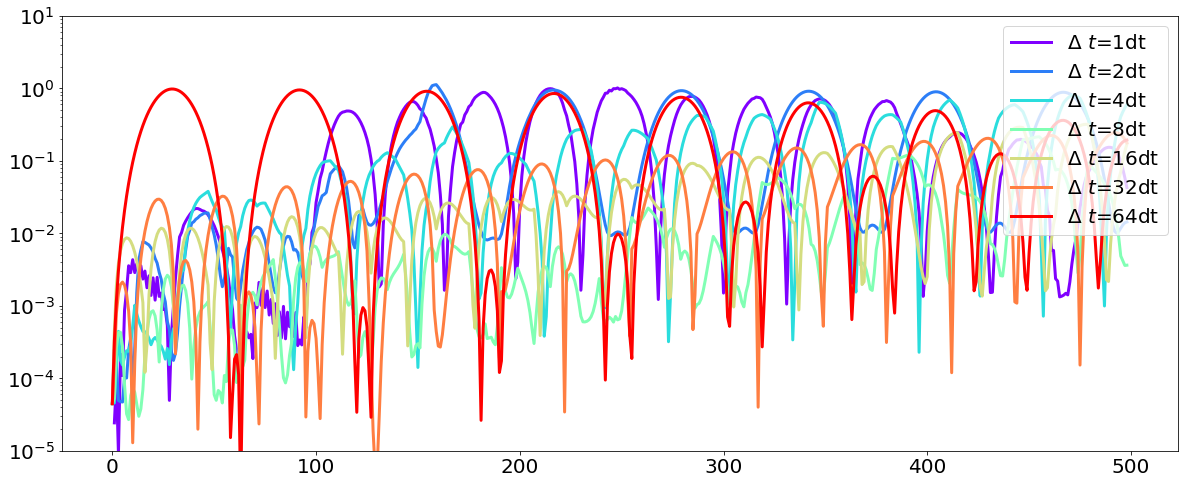

In [11]:
# # uniscale time-stepping with NN
preds_mse = list()
times = list()

for model in tqdm(time_models):
    start = time.time()
#     print(val_encoded.shape)
    y_preds = model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps)
#     print("y_preds.shape =", y_preds.shape)
    end = time.time()
    times.append(end - start)
    print('criterion(torch.tensor(val_encoded[:, 1:, :]).float(), y_preds) shape =', criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1).shape )
    preds_mse.append(criterion(torch.tensor(val_data[:, 1:, :]).float(), y_preds).mean(-1))
#     print("len(preds_mse) = ", len(preds_mse))
    
print(len(preds_mse))
print(len(preds_mse[0]))
# visualize forecasting error at each time step    
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
# print(len(colors))
for k in range(max_k-min_k):
    print("k = ", k)
    err = preds_mse[k]
#     print('err.shape = ', err.shape)
    mean = err[0].detach().numpy()
    rgb = next(colors)
#     print(mean.shape)
#     print(len(t))
#     print(t)
    plt.semilogy(mean, linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])
plt.show()
# plt.xlim([0, len(t)])
    

K =  0 : step_size =  1 : mean =  nan
K =  1 : step_size =  2 : mean =  0.2509748
K =  2 : step_size =  4 : mean =  0.16177002
K =  3 : step_size =  8 : mean =  0.020583667
K =  4 : step_size =  16 : mean =  0.046406515
K =  5 : step_size =  32 : mean =  0.01979348
K =  6 : step_size =  64 : mean =  0.0011304311


(1e-05, 10)

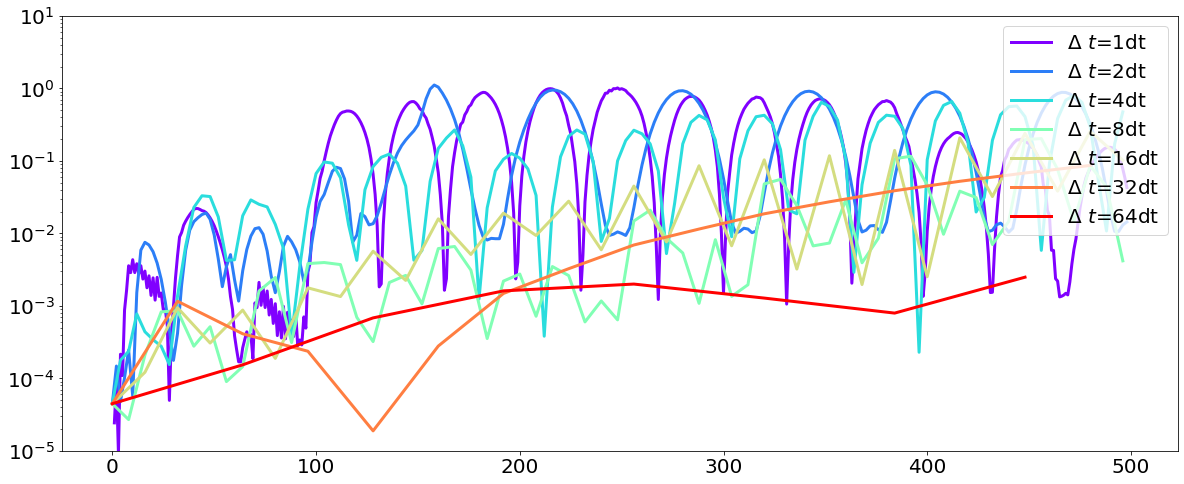

In [12]:
fig = plt.figure(figsize=(20, 8))
colors=iter(plt.cm.rainbow(np.linspace(0, 1, max_k-min_k)))
print(colors)
for k in range(max_k-min_k):
    err = preds_mse[k]
    mean = err.mean(0).detach().numpy()
#     print(np.mean(mean[::step_every]))
    rgb = next(colors)
    step_every = step_sizes[k]
    t = range(len(mean))
    plt.semilogy(t[::step_every], mean[::step_every], linestyle='-', color=rgb, linewidth=3.0, label='$\Delta\ t$={}dt'.format(step_sizes[k]))
    print("K = ", k,": step_size = ", step_sizes[k], ": mean = ", mean[::step_every].mean())
plt.legend(fontsize=20, loc='upper right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.ylim([1e-5, 10])

In [19]:
k = 6
y_preds = np.array(model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps,interpolate = False))
# y_preds = y_preds.detach().numpy()

print("y_preds shape = ", y_preds.shape)
plt.imshow(y_preds[0,-1].reshape(2,2))
plt.colorbar()
plt.show()

plt.imshow(val_data[0,-1].reshape(2,2))
plt.colorbar()
plt.show()

y_preds shape =  (9,)


<ipython-input-19-a706ee755e30>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = np.array(model.uni_scale_forecast(torch.tensor(val_data[:, 0, :]).float(), n_steps=n_steps,interpolate = False))


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
#need to predict encoded dta in time and then decode

print(n_steps)
train_preds_time = model.uni_scale_forecast(torch.tensor(train_encoded[:, 0, :]).float(), n_steps=len(train_encoded[0])-1)
val_preds_time = model.uni_scale_forecast(torch.tensor(val_encoded[:, 0, :]).float(), n_steps=n_steps)
test_preds_time = model.uni_scale_forecast(torch.tensor(test_encoded[:, 0, :]).float(), n_steps=len(test_encoded[0])-1)
print(criterion(torch.tensor(train_encoded[:, 1:, :]).float(), train_preds_time).mean(-1).mean())
print(criterion(torch.tensor(val_encoded[:, 1:, :]).float(), val_preds_time).mean(-1).mean())
print(criterion(torch.tensor(test_encoded[:, 1:, :]).float(), test_preds_time).mean(-1).mean())
# train_encoded

#decode
print(train_preds_time.reshape((3499,3,3)).shape)
to_decode_train = torch.tensor(train_preds_time.reshape((3499,3,3))).unsqueeze(1).float()
train_decoded = model_space.decode(to_decode_train, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(train_decoded.shape)

print(val_preds_time.shape)
to_decode_val = torch.tensor(val_preds_time.reshape((999,3,3))).unsqueeze(1).float()
val_decoded = model_space.decode(to_decode_val, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))

print(test_preds_time.shape)
to_decode_test = torch.tensor(test_preds_time.reshape((len(test_preds_time[0]),3,3)).unsqueeze(1).float())
test_decoded = model_space.decode(to_decode_test, model_space.cur_level)#.reshape((1, len(train_data), len(encoded[0,0])**2))
print(test_decoded.shape)

In [ ]:
train_preds_time.shape
plt.imshow(train_preds_time[0,500].reshape(3,3))
plt.colorbar()

In [ ]:
print(train_decoded.shape)
plt.imshow(train_decoded[499,0].detach().numpy())
plt.colorbar()
plt.show()
print(train_data.shape)
plt.imshow(train_data[21,0].detach().numpy())
plt.colorbar()
plt.show()

mse =criterion(torch.tensor(train_decoded[:]).float(), train_data[:-1,].float()).mean( axis=(1, 2,3))
print(mse.shape)
plt.semilogy(mse)

In [ ]:

print(test_preds_time.shape)
mse =criterion(torch.tensor(val_decoded[:]).float(), val_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("val error of decoded")
plt.show()

print(test_preds_time.shape)
mse =criterion(torch.tensor(test_decoded[:]).float(), test_data[:-1,].float()).mean( axis=(1,2,3))
print(mse.shape)
plt.semilogy(mse)
plt.title("test error of decoded")

In [ ]:
utils.animate(test_decoded.detach().numpy(), os.path.join(result_path, 'decoded_test_7x7.gif'))

In [ ]:
# torch.tensor(train_decoded[:]).float(), train_data[:-1,].float())
print(train_decoded.shape)
tol = 0.1
fully_resolved, loss, resolved_map = net.check_pixel_level_loss(train_decoded[:499].float(), train_data[1:500,].float(), tol=tol, device = 'cpu')

In [ ]:
print(loss.shape)
plt.imshow(loss.detach().numpy())
plt.colorbar()
plt.show()

plt.imshow(resolved_map.detach().numpy())
plt.colorbar()
plt.show()